#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/LYC.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5729,4/07/2022,9.15,9.21,8.980,9.06,9.06,3278999,1.35,1.75,125.0
5730,5/07/2022,9.12,9.18,8.950,8.99,8.99,1582719,1.35,1.75,125.0
5731,6/07/2022,8.75,8.96,8.500,8.53,8.53,4174514,1.35,1.75,125.0
5732,7/07/2022,8.43,8.49,7.925,8.00,8.00,11241703,1.35,1.75,125.0
5733,8/07/2022,8.31,8.52,8.230,8.36,8.36,6211334,1.35,1.75,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

In [4]:
# # Drop all previous records now in MongoDb
#db.lyc.drop()
# # Insert all the records in the CSV into MongoDb
# Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.lyc.insert_many(records)

In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.lyc.delete_one(
    {'Date': last_date}
)

DELETE: 28/07/2022 8.699999809265137


In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 27/07/2022 8.489999771118164
Previous last date in MongoDb: 27-07-2022. Today's date: 02-08-2022


UPDATE MONGO DB

In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'LYC.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:] #skips first record
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-28,8.76,8.540,8.65,8.72,3305955,8.72
2022-07-29,8.96,8.615,8.82,8.71,3372723,8.71
2022-08-01,9.17,8.860,8.90,9.10,4382085,9.10
2022-08-02,8.98,8.850,8.90,8.88,3741061,8.88


In [8]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,28/07/2022,8.76,8.540,8.65,8.72,3305955,8.72,1.35,2.5,125
1,29/07/2022,8.96,8.615,8.82,8.71,3372723,8.71,1.35,2.5,125
2,01/08/2022,9.17,8.860,8.90,9.10,4382085,9.10,1.35,2.5,125
3,02/08/2022,8.98,8.850,8.90,8.88,3741061,8.88,1.35,2.5,125


In [9]:
records=stock_quote.to_dict('records',)
print(records)

[{'Date': '28/07/2022', 'High': 8.760000228881836, 'Low': 8.539999961853027, 'Open': 8.649999618530273, 'Close': 8.720000267028809, 'Volume': 3305955, 'Adj Close': 8.720000267028809, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '29/07/2022', 'High': 8.960000038146973, 'Low': 8.614999771118164, 'Open': 8.819999694824219, 'Close': 8.710000038146973, 'Volume': 3372723, 'Adj Close': 8.710000038146973, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '01/08/2022', 'High': 9.170000076293945, 'Low': 8.859999656677246, 'Open': 8.899999618530273, 'Close': 9.100000381469727, 'Volume': 4382085, 'Adj Close': 9.100000381469727, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '02/08/2022', 'High': 8.979999542236328, 'Low': 8.850000381469727, 'Open': 8.899999618530273, 'Close': 8.880000114440918, 'Volume': 3741061, 'Adj Close': 8.880000114440918, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}]


In [10]:

db.lyc.insert_many(records)
#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_vals = df_mongo.iloc[-10:].values
last_vals

array([[ObjectId('62dcf77def27b9b2d9ba6cd8'), '20/07/2022',
        8.180000305175781, 8.470000267028809, 8.079999923706055,
        8.420000076293945, 8.420000076293945, 5035671, 1.35, 1.75, 125.0],
       [ObjectId('62e215b8b468768a09acc557'), '21/07/2022',
        8.4399995803833, 8.470000267028809, 8.130000114440918,
        8.34000015258789, 8.34000015258789, 4447039, 1.35, 1.75, 125.0],
       [ObjectId('62e215b8b468768a09acc558'), '22/07/2022',
        8.3100004196167, 8.46500015258789, 8.15999984741211,
        8.300000190734863, 8.300000190734863, 3884810, 1.35, 1.75, 125.0],
       [ObjectId('62e215b8b468768a09acc559'), '25/07/2022',
        8.220000267028809, 8.359999656677246, 8.220000267028809,
        8.34000015258789, 8.34000015258789, 2001008, 1.35, 1.75, 125.0],
       [ObjectId('62e215b8b468768a09acc55a'), '26/07/2022',
        8.359999656677246, 8.609999656677246, 8.359999656677246,
        8.550000190734863, 8.550000190734863, 3296130, 1.35, 1.75, 125.0],
       [Ob

In [11]:
import pandas as pd
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_val_10 = df_mongo.iloc[-1:].values
last_date = last_val_10[-1][1]
last_close = last_val_10[-1][5]
print(last_close,last_date)

8.880000114440918 02/08/2022


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.lyc.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5751, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4601, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.02178009, 0.02077296, 0.01976587, 0.01976587, 0.01976587,
       0.01875878, 0.02178009, 0.01875878, 0.02278718, 0.02278718,
       0.02278718, 0.02278718, 0.02178009, 0.02178009, 0.01875878,
       0.02077296, 0.02077296, 0.02077296, 0.01976587, 0.02077296,
       0.02379427, 0.03185099, 0.03285808, 0.03487226, 0.03688644,
       0.04192193, 0.03789353, 0.04393611, 0.04595029, 0.04796447,
       0.04595029, 0.04595029, 0.04192193, 0.03789353, 0.03990775,
       0.03890066, 0.04192193, 0.03990775, 0.03990775, 0.03789353,
       0.03587935, 0.03285808, 0.03185099, 0.03487226, 0.03688644,
       0.03990775, 0.03789353, 0.03386517, 0.03587935, 0.03587935,
       0.03587935, 0.04192193, 0.03990775, 0.03990775, 0.0449432 ,
       0.03990775, 0.04393611, 0.03990775, 0.03890066, 0.03890066])]
[0.03890066154311104]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4541, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4541, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4541/4541 [==============================] - 68s 15ms/step - loss: 0.0010


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.0183379671645521

C:\Users\antoi\AppData\Local\Temp/ipykernel_27792/3474577724.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


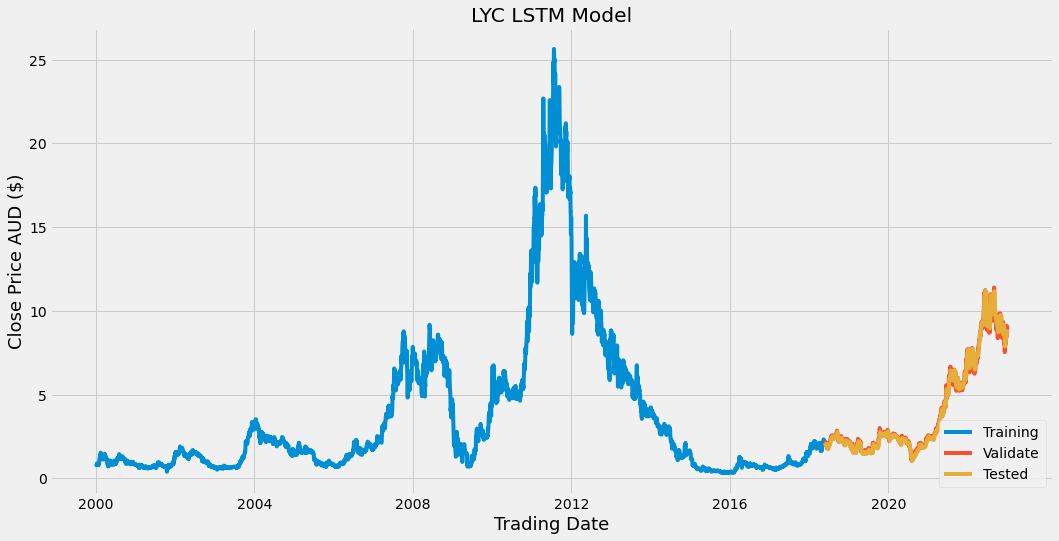

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('LYC LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/lyc_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_27792/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of          Close  Predictions  Difference
4601  2.100921     2.126303   -0.025382
4602  2.031876     2.101973   -0.070097
4603  1.982559     2.057464   -0.074905
4604  2.002286     2.004715   -0.002429
4605  2.150238     1.969968    0.180270
...        ...          ...         ...
5746  8.490000     8.527723   -0.037724
5747  8.720000     8.570439    0.149561
5748  8.710000     8.660704    0.049296
5749  9.100000     8.733590    0.366410
5750  8.880000     8.897622   -0.017622

[1150 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wbc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $8.880000114440918 Predicted next day share price $20.89


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/lyc_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list lyc_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/lyc_model.sav')

In [32]:
# query the lyc collection and load into dataframe

df_mongo = pd.DataFrame(list(db.lyc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[7.895     ],
       [8.24      ],
       [8.47      ],
       [8.57      ],
       [8.65      ],
       [8.94      ],
       [9.58      ],
       [9.38      ],
       [9.425     ],
       [9.5       ],
       [9.47      ],
       [9.29      ],
       [9.29      ],
       [9.36      ],
       [9.56      ],
       [9.8       ],
       [9.15      ],
       [9.09      ],
       [9.36      ],
       [9.32      ],
       [9.35      ],
       [9.52      ],
       [9.09      ],
       [8.31      ],
       [7.81      ],
       [8.5       ],
       [8.85      ],
       [8.47      ],
       [8.21      ],
       [8.49      ],
       [8.29      ],
       [8.24      ],
       [8.275     ],
       [8.87      ],
       [9.1       ],
       [8.79      ],
       [8.61      ],
       [8.78      ],
       [8.98      ],
       [8.95      ],
       [8.5       ],
       [7.925     ],
       [8.23      ],
       [7.94000006],
       [7.51999998],
       [7.42000008],
       [7.75      ],
       [7.809

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/lyc_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_lyc(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_lyc(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[8.74,
 8.77,
 8.77,
 8.77,
 8.76,
 8.74,
 8.73,
 8.73,
 8.72,
 8.71,
 8.71,
 8.71,
 8.71,
 8.71,
 8.71,
 8.72,
 8.72,
 8.72,
 8.72,
 8.72,
 8.72,
 8.73,
 8.71,
 8.71,
 8.71,
 8.7,
 8.7,
 8.69,
 8.69,
 8.68,
 8.68,
 8.68,
 8.67,
 8.67,
 8.67,
 8.66,
 8.65,
 8.65,
 8.64,
 8.64,
 8.63,
 8.62,
 8.61,
 8.61,
 8.6,
 8.59,
 8.6,
 8.59,
 8.59,
 8.59,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,
 8.6,


In [34]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,11/07/2022,Monday
1,2,12/07/2022,Tuesday
2,3,13/07/2022,Wednesday
3,4,14/07/2022,Thursday
4,5,15/07/2022,Friday
...,...,...,...
260,261,10/07/2023,Monday
261,262,11/07/2023,Tuesday
262,263,12/07/2023,Wednesday
263,264,13/07/2023,Thursday


C:\Users\antoi\AppData\Local\Temp/ipykernel_27792/2869323903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


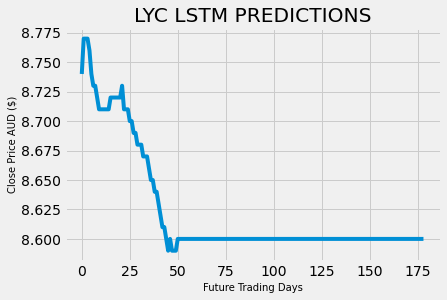

In [35]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('LYC LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/lyc_pred.png', bbox_inches="tight")
plt.show()

In [36]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 8.74},
 {'Price': 8.77},
 {'Price': 8.77},
 {'Price': 8.77},
 {'Price': 8.76},
 {'Price': 8.74},
 {'Price': 8.73},
 {'Price': 8.73},
 {'Price': 8.72},
 {'Price': 8.71},
 {'Price': 8.71},
 {'Price': 8.71},
 {'Price': 8.71},
 {'Price': 8.71},
 {'Price': 8.71},
 {'Price': 8.72},
 {'Price': 8.72},
 {'Price': 8.72},
 {'Price': 8.72},
 {'Price': 8.72},
 {'Price': 8.72},
 {'Price': 8.73},
 {'Price': 8.71},
 {'Price': 8.71},
 {'Price': 8.71},
 {'Price': 8.7},
 {'Price': 8.7},
 {'Price': 8.69},
 {'Price': 8.69},
 {'Price': 8.68},
 {'Price': 8.68},
 {'Price': 8.68},
 {'Price': 8.67},
 {'Price': 8.67},
 {'Price': 8.67},
 {'Price': 8.66},
 {'Price': 8.65},
 {'Price': 8.65},
 {'Price': 8.64},
 {'Price': 8.64},
 {'Price': 8.63},
 {'Price': 8.62},
 {'Price': 8.61},
 {'Price': 8.61},
 {'Price': 8.6},
 {'Price': 8.59},
 {'Price': 8.6},
 {'Price': 8.59},
 {'Price': 8.59},
 {'Price': 8.59},
 {'Price': 8.6},
 {'Price': 8.6},
 {'Price': 8.6},
 {'Price': 8.6},
 {'Price': 8.6},
 {'Price': 8.6},
 {

In [37]:
# len_df_mongo = len(df.index) # length of the original dataframe
len_df_mongo=len(df_mongo)
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4601 5751 5914


,Close
5903,8.6
5904,8.6
5905,8.6
5906,8.6
5907,8.6
5908,8.6
5909,8.6
5910,8.6
5911,8.6
5912,8.6


C:\Users\antoi\AppData\Local\Temp/ipykernel_27792/1830226815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


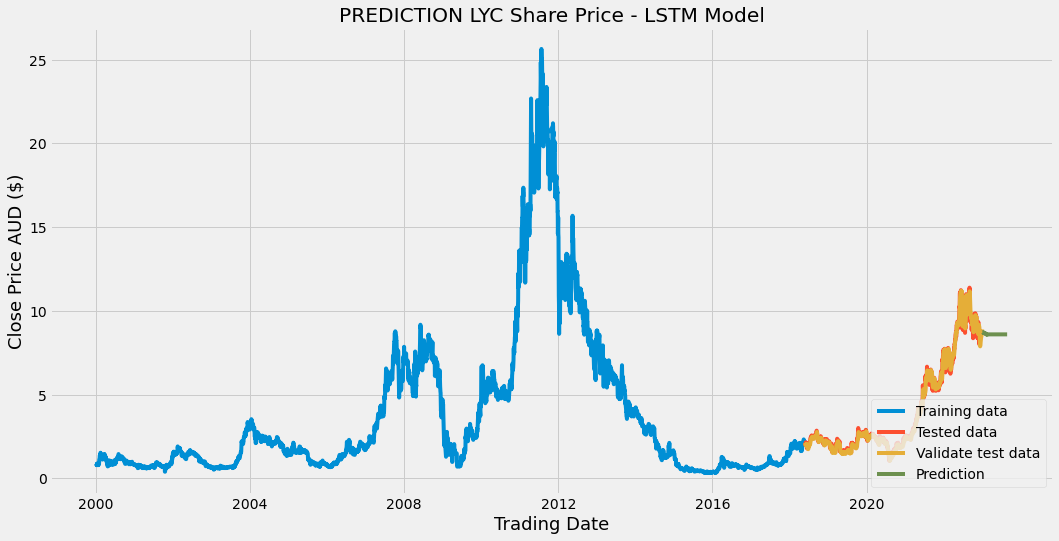

In [38]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION LYC Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/lyc_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [39]:
# Query all
name = 'LYC'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62e21618b468768a09acc55d'), 'model': 'LSTM', 'name': 'LYC', 'date': '28/07/2022', 'predicted': 18.23, 'actual': 8.7, 'differece': 9.530000000000001, 'rmse': 0.14555}
{'_id': ObjectId('62e36d4d3ecef61f4fa45c4f'), 'model': 'RFR', 'name': 'LYC', 'date': '28/07/2022', 'predicted': 6, 'actual': 8, 'differece': -1.6143369469894608, 'accuracy': 89.99}


In [40]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e36d4d3ecef61f4fa45c4f'), 'model': 'RFR', 'name': 'LYC', 'date': '28/07/2022', 'predicted': 6, 'actual': 8, 'differece': -1.6143369469894608, 'accuracy': 89.99}


In [41]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 02/08/2022, predicted $20.89, actual $8.88, difference 12.01, rmse 0.01834


In [42]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e36d4d3ecef61f4fa45c4f'), 'model': 'RFR', 'name': 'LYC', 'date': '28/07/2022', 'predicted': 6, 'actual': 8, 'differece': -1.6143369469894608, 'accuracy': 89.99}
{'_id': ObjectId('62e8d1006268ec69462793ef'), 'model': 'LSTM', 'name': 'LYC', 'date': '02/08/2022', 'predicted': 20.89, 'actual': 8.88, 'difference': 12.01, 'rmse': 0.01834}


In [43]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e219cf92eb597dfa71446b'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/07/2022', 'predicted': 29.89, 'actual': 30.28, 'differece': -0.39000000000000057, 'rmse': 0.4037}
{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date':